# Jugend Forscht 
## Datenanalyse selbst gesammelter Daten 10.02.2024

Zunächst laden wir die Dependencies...

In [22]:
import subprocess
import time
import json
import matplotlib.pyplot as plt 
import csv 
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns  
import pickle
from itertools import islice
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from scipy import stats

In [23]:
# DIR-PATHS
avg_fee_block_path = '/home/oscar/jufobtc/data/fees_750.csv'
median_fee_block_path = '/home/oscar/jufobtc/data/median_fees_750.csv'
mempool_tx_path = '/home/oscar/jufobtc/data/mem_tx.csv'
fee_comp_path = '/home/oscar/jufobtc/data/fee_estimator_comp.csv'
tx_times_path = '/home/oscar/jufobtc/data/tx_times.csv'

... und die Daten.

In [24]:
# LOAD DATA

avg_fee_block = open(avg_fee_block_path, 'r')
col = ['timestamp', 'blockheight', 'avg_fee']
df_avg_fee = pd.read_csv(avg_fee_block, delimiter=' ', names=col)

median_fee_block = open(median_fee_block_path, 'r')
col = ['timestamp', 'blockheight', 'median_fee']
df_median_fee = pd.read_csv(median_fee_block, delimiter=' ', names=col)


mempool_tx = open(mempool_tx_path, 'r')
col = ['txhash', 'timestamp']
df_mempool_tx = pd.read_csv(mempool_tx, delimiter=' ', names=col)


fee_comp = open(fee_comp_path, 'r')
col = ['blockheight', 'mem.space_est', 'bitcoincore_est', 'wtfee_est', 'timestamp'] # blockheight steht für den block, für den die Prognose ist
df_fee_comp = pd.read_csv(fee_comp, delimiter=' ', names=col)

tx_times = open(tx_times_path, 'r')
col = ['txhash', 'difftime', 'blockheight']
df_tx_times = pd.read_csv(tx_times, names=col, delimiter=' ')



### Zusammenführung der Daten
Nun mergen wir die Datensätze A Vergleich der Gebührenvorhersage und B der durchschnittlichen Gebühren. Außerdem droppen wir alle Einträge bis auf den letzten vor der Bestätigung des nächsten Blockes. Demnach haben wir immer die aktuellste Vorhersage.

In [25]:
#MERGE DATA
df_fee_comp = pd.merge(df_fee_comp, df_avg_fee, on='blockheight')
df_fee_comp = df_fee_comp.drop_duplicates("blockheight", keep='last')
#print(df_fee_comp)

### Berechnungen Gebührenvorhersagen
Für eine bessere Vergleichbarkeit der Schätzungen berechnen wir noch einige Differenzen:
- Gebührenänderung  
- Änderung der Gebührenprognose  
- Blockerstellungszeiten

TODO: Differenzen zwischen den einzelnen Schätzern berechnen. 

In [26]:
# CALCs
df_fee_comp["change_avg_fee"] = df_fee_comp["avg_fee"].diff()
df_fee_comp["change_fee_est_bitcoincore"] = df_fee_comp['bitcoincore_est'].diff()
df_fee_comp["change_fee_est_mem.space"] = df_fee_comp['mem.space_est'].diff()
df_fee_comp["change_fee_est_wtfee"] = df_fee_comp['wtfee_est'].diff()
df_fee_comp["blocktime"] = df_fee_comp["timestamp_y"].diff()

df_avg_fee["blocktime"] = df_avg_fee["timestamp"].diff()
df_avg_fee["change_avg_fee"] = df_avg_fee["avg_fee"].diff()

#print(df_fee_comp.loc[df_fee_comp["change_avg_fee"] & df_fee_comp["change_avg_fee"] ])

print(df_fee_comp.head(2))

     blockheight  mem.space_est  bitcoincore_est  wtfee_est   timestamp_x  \
15        828799             42          188.885       54.6  1.707003e+09   
103       828800             87          188.892       54.6  1.707006e+09   

     timestamp_y     avg_fee  change_avg_fee  change_fee_est_bitcoincore  \
15    1707003120   79.875828             NaN                         NaN   
103   1707005774  163.300143       83.424315                       0.007   

     change_fee_est_mem.space  change_fee_est_wtfee  blocktime  
15                        NaN                   NaN        NaN  
103                      45.0                   0.0     2654.0  


### Bereinigung des Datensatzes für Transaktionsbestätigungszeiten

1. Tx mit einer Zeit von kleiner als 0 auf 0 setzen -> bedeutet direkte Bestätigung in Block (potenzielle Ursache könnte die ungenaue Zeit im Blocktimestamp sein)
2. Abziehung der Blockerstellungszeiten von tx zeiten
   1. Merge mit Datensatz mit Gebühren und Blocktimestamps
   2. => Verminderung des Einflusses der Varianz der Blockerstellungszeiten


In [27]:
# CALCs 2
df_tx_times["difftime"].loc[df_tx_times["difftime"]<0] = 0
df_tx_times = df_tx_times.dropna()
df_tx_times = pd.merge(df_tx_times, df_avg_fee, on="blockheight")

df_tx_times["cl_difftime"] = df_tx_times["difftime"] - df_tx_times["blocktime"]

/tmp/ipykernel_127463/3986202643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tx_times["difftime"].loc[df_tx_times["difftime"]<0] = 0


### Berechnung der Mediane für Zeiten der Blöcke
Vorteile:
- Bessere Vergleichbarkeit   
- Vereinfachte Messungen  

Nachteile:
- Beispielsweise CPFP ist nicht berücksichtigt  

In [28]:
temp = pd.DataFrame(columns=[ "median_difftime"])
temp["median_difftime"] =  df_tx_times.groupby(['blockheight'])["cl_difftime"].median()
temp["blockheight"] = temp.index
temp.index.names = ["index"]
df_only_fees = df_avg_fee
df_avg_fee = pd.merge(df_avg_fee, temp, on='blockheight')
#print(df_avg_fee)
                                                                                    

### Zusammenführung aller Datensätze 

In [29]:
data = pd.merge(df_avg_fee, df_fee_comp, on="blockheight")

data = data.drop(columns=["timestamp_x","avg_fee_y","blocktime_y"])

data = data.rename(columns={'blocktime_x': 'blocktime', 'timestamp_y': 'timestamp', 'avg_fee_x': 'avg_fee'})

data["blockheight"].astype(int)



0       828890
1       828891
2       828892
3       828893
4       828894
         ...  
1500    830990
1501    830991
1502    830992
1503    830993
1504    830994
Name: blockheight, Length: 1505, dtype: int64

In [30]:
print(df_median_fee)

        timestamp  blockheight  median_fee
0      1660845772       750000          12
1      1660845812       750001          11
2      1660846977       750002          13
3      1660847493       750003           9
4      1660847819       750004           5
...           ...          ...         ...
81455  1708554465       831455          24
81456  1708554705       831456          16
81457  1708554854       831457          14
81458  1708555670       831458          19
81459  1708556252       831459          15

[81460 rows x 3 columns]


In [31]:
print(stats.kstest(df_avg_fee["median_difftime"][df_avg_fee["change_avg_fee"].shift(-1)<0] ,df_avg_fee["median_difftime"][df_avg_fee["change_avg_fee"].shift(-1)>0]))


KstestResult(statistic=0.40550141772316917, pvalue=9.671656869123065e-78, statistic_location=-167.5, statistic_sign=1)


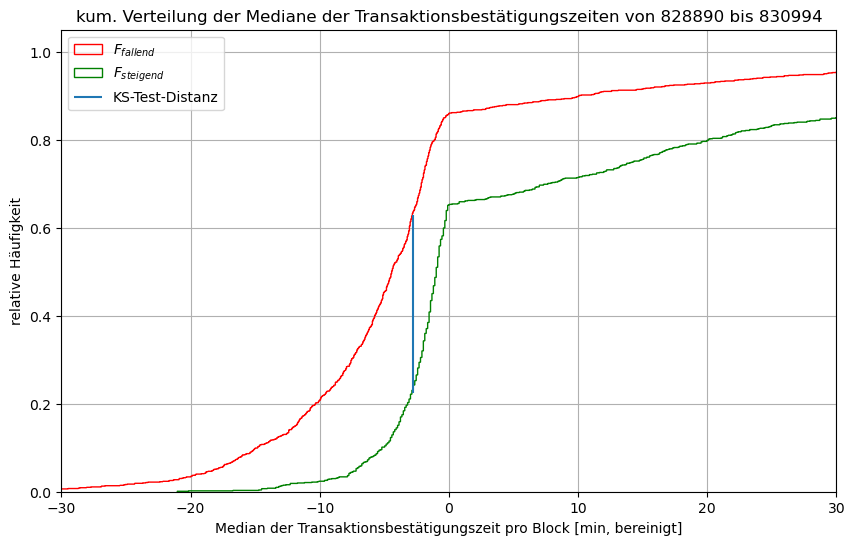

In [32]:
plt.figure(figsize=(10,6))

plt.hist(df_avg_fee["median_difftime"].loc[df_avg_fee["change_avg_fee"].shift(-1)<0]/60, cumulative=True, density=True, bins=100000, label='$F_{fallend}$', histtype='step', color="red")
plt.hist(df_avg_fee["median_difftime"].loc[df_avg_fee["change_avg_fee"].shift(-1)>0]/60, cumulative=True, density=True, bins=100000, label='$F_{steigend}$', histtype='step', color="green")
ymin=0.225
plt.vlines(x=-167.5/60, ymin=ymin, ymax=(ymin+0.405), label="KS-Test-Distanz")

plt.xlim(-30, 30)

plt.ylabel('relative Häufigkeit')
plt.xlabel("Median der Transaktionsbestätigungszeit pro Block [min, bereinigt]")
plt.title('kum. Verteilung der Mediane der Transaktionsbestätigungszeiten von {} bis {}'.format(str(df_avg_fee["blockheight"].min()), str(df_avg_fee["blockheight"].max())))
plt.legend()
plt.grid()




       blockheight  mem.space_est  bitcoincore_est  wtfee_est   timestamp_x  \
21449       831459             15           24.563       24.5  1.708556e+09   
21451       831460             14           24.563       24.5  1.708556e+09   
21481       831461             25           24.563       24.5  1.708558e+09   
21483       831462             17           24.564       24.5  1.708558e+09   
21486       831463             14           24.564       24.5  1.708558e+09   

       timestamp_y    avg_fee  change_avg_fee  change_fee_est_bitcoincore  \
21449   1708556252  18.742978       -3.903573                       0.000   
21451   1708556342  14.649066       -4.093912                       0.000   
21481   1708558181  29.426697       14.777631                       0.000   
21483   1708558321  17.485191      -11.941507                       0.001   
21486   1708558488  15.436653       -2.048537                       0.000   

       change_fee_est_mem.space  change_fee_est_wtfee  blockti

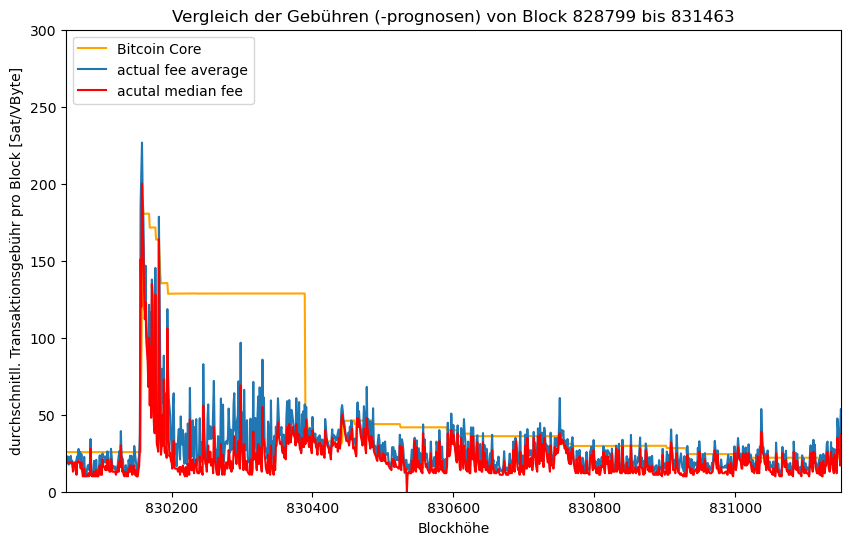

In [33]:
# OVERVIEW DATA
plt.figure(figsize=(10,6))
plt.xlim(830050,831150)
plt.ylim(0,300)

#plt.plot(df_fee_comp["blockheight"],df_fee_comp['mem.space_est'], label='Mempool.Space')
plt.plot(df_fee_comp["blockheight"],df_fee_comp['bitcoincore_est'], label='Bitcoin Core', color="orange")
#plt.plot(df_fee_comp["blockheight"],df_fee_comp['wtfee_est'], label="What the Feee")
plt.plot(df_fee_comp["blockheight"],df_fee_comp["avg_fee"], label='actual fee average')
plt.plot(df_median_fee["blockheight"], df_median_fee["median_fee"], label="acutal median fee", color="red")

plt.legend(loc='upper left')
plt.ticklabel_format(useOffset=False)

plt.title('Vergleich der Gebühren (-prognosen) von Block {} bis {}'.format(df_fee_comp["blockheight"].min(),df_fee_comp["blockheight"].max()))
plt.xlabel('Blockhöhe')
plt.ylabel('durchschnitll. Transaktionsgebühr pro Block [Sat/VByte]')

print(df_fee_comp.tail(5))

(array([1.22107577e-05, 1.22107577e-05, 1.22107577e-05, ...,
        9.99987789e-01, 9.99987789e-01, 1.00000000e+00]),
 array([-3624.55      , -3624.51253733, -3624.47507467, ...,
          121.64174133,   121.679204  ,   121.71666667]),
 [<matplotlib.patches.Polygon at 0x7f9fb83faf50>])

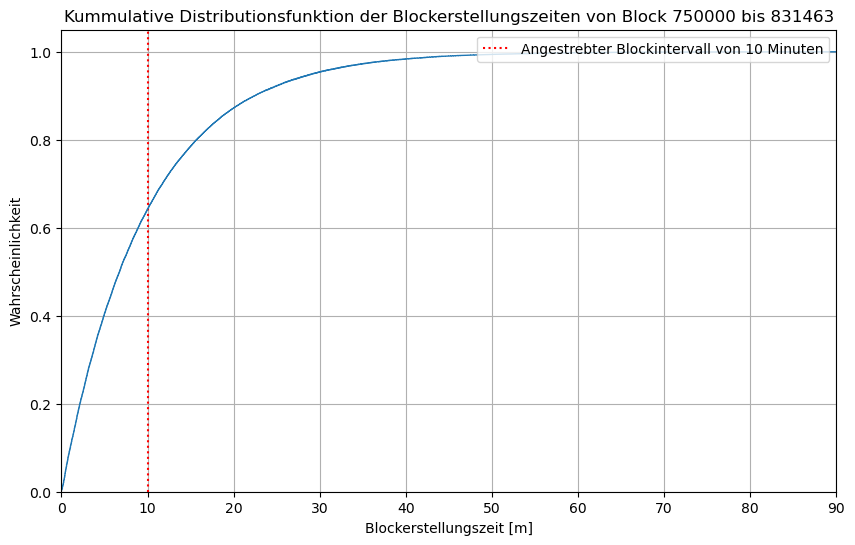

In [34]:
start, end = df_only_fees["blockheight"].min(), df_only_fees["blockheight"].max()
plt.figure(figsize=(10,6))
plt.title('Kummulative Distributionsfunktion der Blockerstellungszeiten von Block {} bis {}'.format(start, end))
plt.ylabel('Wahrscheinlichkeit')
plt.xlabel('Blockerstellungszeit [m]')
plt.axvline(x=10, ls=':', c='red',label='Angestrebter Blockintervall von 10 Minuten')
#plt.axhline(y=0.635)
list = []
for i in range(0,14):
    list.append(i*10)
plt.xticks(list)
plt.grid()
plt.xlim(0,90)
plt.legend(loc=('upper right'))
plt.hist(df_only_fees['blocktime']/60,histtype='step',bins=100000, density=True, cumulative=True)

<BarContainer object of 1 artists>

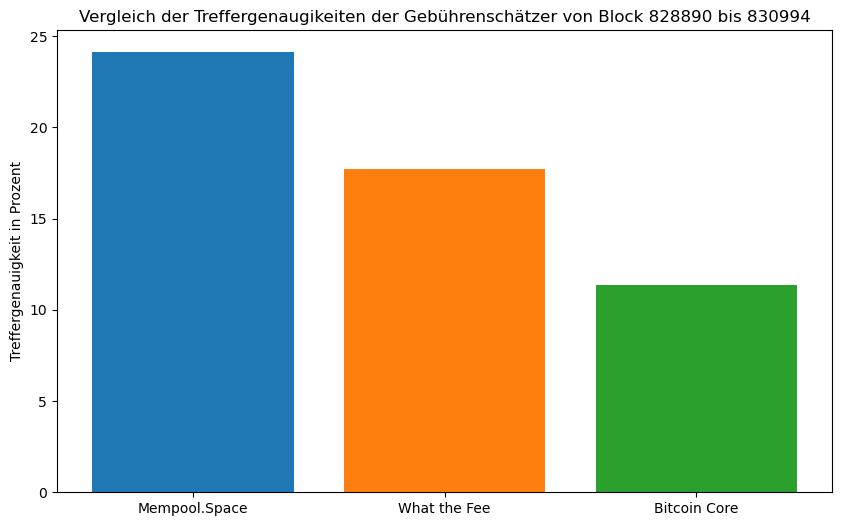

In [35]:
k = 2.5
'''
print(data["blockheight"][abs(data["wtfee_est"] - data["avg_fee"]) < k ].count())
print(data["blockheight"][abs(data["mem.space_est"] - data["avg_fee"]) < k ].count())
print(data["blockheight"][abs(data["bitcoincore_est"] - data["avg_fee"]) < k ].count())

print(data["blockheight"][(data["bitcoincore_est"] > data["avg_fee"].shift(-1)) & data["change_avg_fee_x"] > 0].count())
'''


total_entries = data["blockheight"].count()

plt.figure(figsize=(10,6))
plt.ylabel("Treffergenauigkeit in Prozent")


plt.title("Vergleich der Treffergenaugikeiten der Gebührenschätzer von Block {} bis {}".format(data["blockheight"].min(),data["blockheight"].max() ))
plt.bar(x="Mempool.Space", height=(data["blockheight"][abs(data["mem.space_est"] - data["avg_fee"]) < k ].count())/total_entries*100)
plt.bar(x="What the Fee", height=(data["blockheight"][abs(data["wtfee_est"] - data["avg_fee"]) < k ].count())/total_entries*100)
plt.bar(x="Bitcoin Core", height=(data["blockheight"][abs(data["bitcoincore_est"] - data["avg_fee"]) < k ].count())/total_entries*100)



### Berechnunng eigener Trefferwahrscheinlichkeit (Higher/Lower)

- backtesting (?)
- welche Werte zählen wir rein?
  - schwellenwert für fallende tx ? (und steigende ?)

In [14]:
k1 = 60*20
shift = 2

print("median größer als {} und fallende Gebühr: ".format(k1), (df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1) & (df_avg_fee["change_avg_fee"].shift(shift) < 0)]).count())
print("median größer als {} und steigende Gebühr: ".format(k1), (df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1) & (df_avg_fee["change_avg_fee"].shift(shift) > 0)]).count())
print("total median größer als {}: ".format(k1), df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1)].count())

print("ratio richtig: ",((df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1) & (df_avg_fee["change_avg_fee"].shift(shift) < 0)]).count())/(df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1)]).count())

k = -60*10

print("median kleiner als {} und fallende Gebühr: ".format(k), df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k) & (df_avg_fee["change_avg_fee"].shift(shift) < 0)].count())
print("median kleiner als {} und steigende Gebühr: ".format(k), df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k) & (df_avg_fee["change_avg_fee"].shift(shift) > 0)].count())
print("total median größer als {}: ".format(k), df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k)].count())

print("ratio richtig: ",(df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k) & (df_avg_fee["change_avg_fee"].shift(shift) > 0)].count())/df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k)].count())


print(df_avg_fee["blockheight"].count())


print("total ratio richtig (higher / lower): ", (((df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1) & (df_avg_fee["change_avg_fee"].shift(shift) < 0)]).count()) + (df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k) & (df_avg_fee["change_avg_fee"].shift(shift) > 0)].count()))/(df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]>k1)].count() + df_avg_fee["blockheight"][(df_avg_fee["median_difftime"]<k)].count()))

median größer als 1200 und fallende Gebühr:  147
median größer als 1200 und steigende Gebühr:  136
total median größer als 1200:  283
ratio richtig:  0.519434628975265
median kleiner als -600 und fallende Gebühr:  127
median kleiner als -600 und steigende Gebühr:  123
total median größer als -600:  251
ratio richtig:  0.4900398406374502
2105
total ratio richtig (higher / lower):  0.5056179775280899


'\nprint(temp["blockheight"].count())\nprint(temp[["blockheight", "median_difftime"]][temp["median_difftime"] < k_low])\nprint(temp[["blockheight", "median_difftime"]][temp["median_difftime"] > k_high])\n\n'

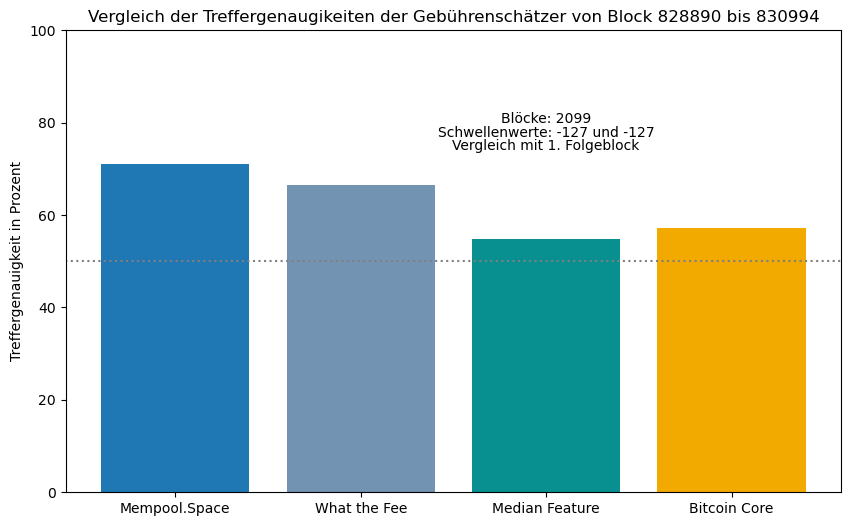

In [15]:

total_entries = data["blockheight"].count()
moving_average = 3

height_mempool_space = ((data["blockheight"][((data["mem.space_est"] > data["avg_fee"].shift(1)) & (data["change_avg_fee_x"] > 0)) | ((data["mem.space_est"] < data["avg_fee"].shift(1)) & (data["change_avg_fee_x"] < 0))].count())/total_entries)*100
height_whatthefee = ((data["blockheight"][((data["wtfee_est"] > data["avg_fee"].shift(1)) & (data["change_avg_fee_x"] > 0)) | ((data["wtfee_est"] < data["avg_fee"].shift(1)) & (data["change_avg_fee_x"] < 0))].count())/total_entries)*100
height_bitcoin_core = ((data["blockheight"][((data["bitcoincore_est"] > data["avg_fee"].shift(1)) & (data["change_avg_fee_x"] > 0)) | ((data["bitcoincore_est"] < data["avg_fee"].shift(1)) & (data["change_avg_fee_x"] < 0))].count())/total_entries)*100

k_low, k_high =  -127, -127
shift = -1
temp = df_avg_fee



eigener_estimator_blocks = (temp["blockheight"][(temp["median_difftime"]<k_low)].count() + temp["blockheight"][(temp["median_difftime"]>k_high)].count())
height_eigener_estimator = (((temp["blockheight"][(temp["median_difftime"]>k_high) & (temp["change_avg_fee"] < 0)]).count()) + (temp["blockheight"][(temp["median_difftime"]<k_low) & (temp["change_avg_fee"].shift(shift) > 0)].count()))/eigener_estimator_blocks
height_eigener_estimator2 = (((temp["blockheight"][(temp["median_difftime"]>k_high) & (temp["change_avg_fee"] < 0)]).count()) + (temp["blockheight"][(temp["median_difftime"]<k_low) & (temp["change_avg_fee"].shift(shift-1) > 0)].count()))/eigener_estimator_blocks
height_eigener_estimator = height_eigener_estimator*100




plt.figure(figsize=(10,6))
plt.ylabel("Treffergenauigkeit in Prozent")



plt.title("Vergleich der Treffergenaugikeiten der Gebührenschätzer von Block {} bis {}".format(data["blockheight"].min(),data["blockheight"].max() ))
plt.ylim(0,100)



plt.text(x="Median Feature", y=80, s="Blöcke: {}".format(eigener_estimator_blocks) ,horizontalalignment='center')
plt.text(x="Median Feature", y=77, s="Schwellenwerte: {} und {}".format(k_low, k_high), horizontalalignment='center')
plt.text(x="Median Feature", y=74, s="Vergleich mit {}. Folgeblock".format(-1*(shift))  ,horizontalalignment='center')




plt.hlines(xmin=-1000, xmax=1000, y=50, linestyles=':', colors="grey")

plt.bar(x="Mempool.Space", height=height_mempool_space)
plt.bar(x="What the Fee", height=height_whatthefee, color="#7393B3")
plt.bar(x="Median Feature", height=height_eigener_estimator, color="#088F8F")
plt.bar(x="Bitcoin Core", height=height_bitcoin_core,color="#F2A900")

'''
print(temp["blockheight"].count())
print(temp[["blockheight", "median_difftime"]][temp["median_difftime"] < k_low])
print(temp[["blockheight", "median_difftime"]][temp["median_difftime"] > k_high])

'''





In [16]:
for i in range(-10000,10000):
    j = i
    
    eigener_estimator_blocks = (temp["blockheight"][(temp["median_difftime"]<i)].count() + temp["blockheight"][(temp["median_difftime"]>j)].count())
    height_eigener_estimator = (((temp["blockheight"][(temp["median_difftime"]>j) & (temp["change_avg_fee"] < 0)]).count()) + (temp["blockheight"][(temp["median_difftime"]<i) & (temp["change_avg_fee"].shift(shift) > 0)].count()))/eigener_estimator_blocks
    height_eigener_estimator = height_eigener_estimator*100

    if height_eigener_estimator > 61:
            print(i, j, height_eigener_estimator)
    
    
    

KeyboardInterrupt: 

In [ ]:
for i in range(-10000,0):
    for j in range(-500,10000):
        if i > j: continue
        eigener_estimator_blocks = (temp["blockheight"][(temp["median_difftime"]<i)].count() + temp["blockheight"][(temp["median_difftime"]>j)].count())
        height_eigener_estimator = (((temp["blockheight"][(temp["median_difftime"]>j) & (temp["change_avg_fee"].rolling(moving_average).mean().shift(shift) < 0)]).count()) + (temp["blockheight"][(temp["median_difftime"]<i) & (temp["change_avg_fee"].shift(shift) > 0)].count()))/eigener_estimator_blocks
        height_eigener_estimator = height_eigener_estimator*100

        if height_eigener_estimator > 60 and eigener_estimator_blocks > 1000:
            print(i, j, height_eigener_estimator)
            

KeyboardInterrupt: 

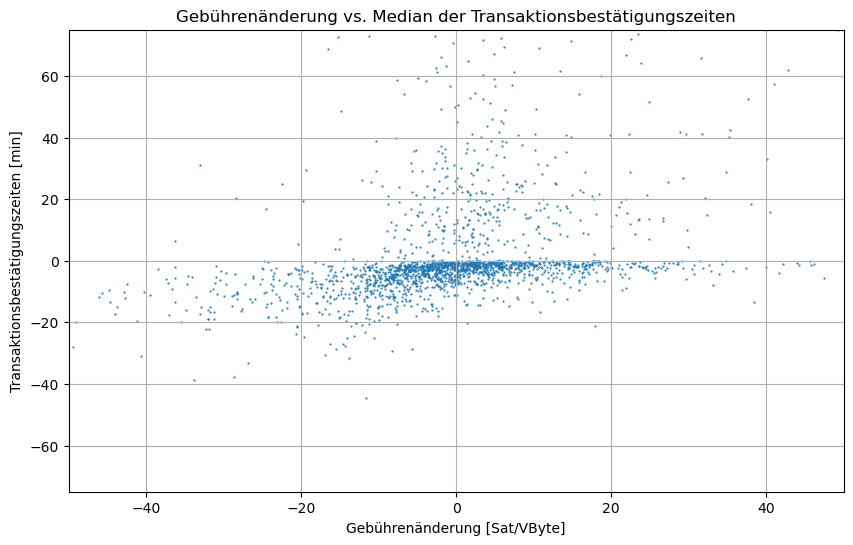

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Gebührenänderung vs. Median der Transaktionsbestätigungszeiten")
plt.ylabel("Transaktionsbestätigungszeiten [min]")
plt.xlabel("Gebührenänderung [Sat/VByte]")

plt.scatter(x=df_avg_fee["change_avg_fee"].shift(-1), y=df_avg_fee["median_difftime"]/60, s=0.3)

plt.xlim(-50,50)
plt.ylim(-75,75)
plt.grid()

43561
38011
81574


/tmp/ipykernel_19855/3964270390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_fees["change_sign"].loc[df_only_fees["change_avg_fee"] > 0] = "p"
/tmp/ipykernel_19855/3964270390.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg_fee["change_sign"].loc[df_avg_fee["change_avg_fee"] < 0] = "n"


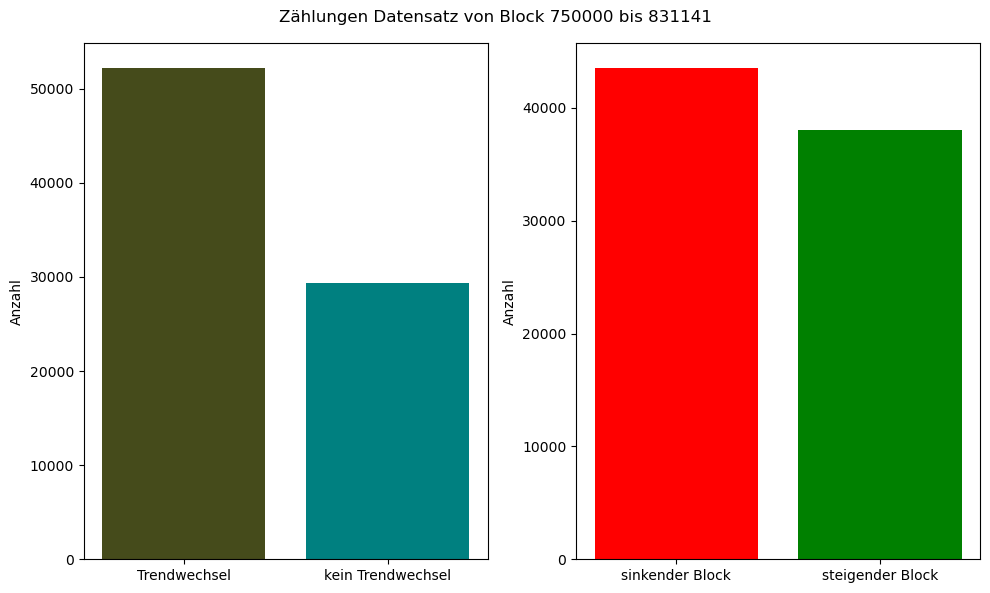

In [ ]:
print(df_only_fees["blockheight"][df_only_fees["change_avg_fee"] < 0 ].count())
print(df_only_fees["blockheight"][df_only_fees["change_avg_fee"] > 0 ].count())
print(df_only_fees["blockheight"].count())

df_only_fees["change_sign"] = 0
df_only_fees["change_sign"].loc[df_only_fees["change_avg_fee"] > 0] = "p"
df_only_fees["change_sign"].loc[df_only_fees["change_avg_fee"] < 0] = "n"

df_avg_fee["change_sign"] = 0
df_avg_fee["change_sign"].loc[df_avg_fee["change_avg_fee"] < 0] = "n"
df_avg_fee["change_sign"].loc[df_avg_fee["change_avg_fee"] > 0] = "p"

#print(df_only_fees["blockheight"][df_only_fees["change_sign"] != df_only_fees["change_sign"].shift(-1)].count())
#print(df_only_fees["blockheight"][df_only_fees["change_sign"] == df_only_fees["change_sign"].shift(-1)].count())

#print("ratio trendwechsel: ", (df_avg_fee["blockheight"][df_avg_fee["change_sign"] != df_avg_fee["change_sign"].shift(-1)].count())/df_avg_fee["blockheight"].count() )


plt.figure(figsize=(10,6))


plt.suptitle("Zählungen Datensatz von Block {} bis {}".format(df_only_fees["blockheight"].min(),df_only_fees["blockheight"].max()))

plt.subplot(1,2,1)
plt.ylabel("Anzahl")

plt.bar(x="Trendwechsel", height=(df_only_fees["blockheight"][df_only_fees["change_sign"] != df_only_fees["change_sign"].shift(-1)].count()), color="#454B1B")
plt.bar(x="kein Trendwechsel", height=(df_only_fees["blockheight"][df_only_fees["change_sign"] == df_only_fees["change_sign"].shift(-1)].count()),color="#008080")

plt.subplot(1,2,2)
plt.ylabel("Anzahl")
plt.bar(x="sinkender Block", height=df_only_fees["blockheight"][df_only_fees["change_avg_fee"] < 0 ].count(), color='red')
plt.bar(x="steigender Block", height=df_only_fees["blockheight"][df_only_fees["change_avg_fee"] > 0 ].count(), color='green')
plt.tight_layout()

In [ ]:
list = []
for block in range(int(df_tx_times["blockheight"].min()), int(df_tx_times["blockheight"].max())):
    if (df_tx_times["blockheight"][df_tx_times["blockheight"] == block].count()) > 0:
        list.append(block)
list.sort(reverse=True)
print(list)

[830993, 830992, 830991, 830990, 830989, 830988, 830987, 830986, 830985, 830984, 830983, 830982, 830981, 830980, 830979, 830978, 830977, 830976, 830975, 830974, 830973, 830972, 830971, 830970, 830969, 830968, 830967, 830966, 830965, 830964, 830963, 830962, 830961, 830960, 830959, 830958, 830957, 830956, 830955, 830954, 830953, 830952, 830951, 830950, 830949, 830948, 830947, 830946, 830945, 830944, 830943, 830942, 830941, 830940, 830939, 830938, 830937, 830936, 830935, 830934, 830933, 830932, 830931, 830930, 830929, 830928, 830927, 830926, 830925, 830924, 830923, 830922, 830921, 830920, 830919, 830918, 830917, 830916, 830915, 830914, 830913, 830912, 830911, 830910, 830909, 830908, 830907, 830906, 830905, 830904, 830903, 830902, 830901, 830900, 830899, 830898, 830897, 830896, 830895, 830894, 830893, 830892, 830891, 830890, 830889, 830888, 830887, 830886, 830885, 830884, 830883, 830882, 830881, 830880, 830879, 830878, 830877, 830876, 830875, 830874, 830873, 830872, 830871, 830870, 830869,

Text(60, 0.52, 'Median')

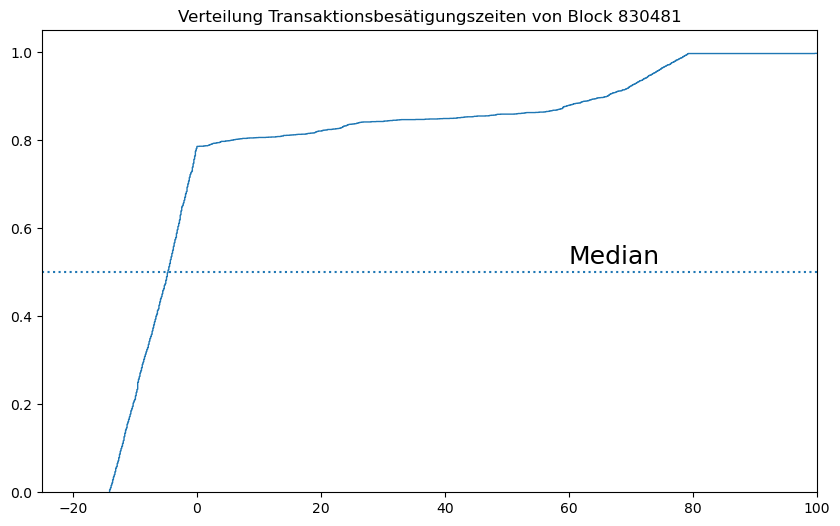

In [ ]:
block = 830481
min, max = -25, 100
plt.figure(figsize=(10,6))
plt.title("Verteilung Transaktionsbesätigungszeiten von Block %s" %str(block))
plt.hist((df_tx_times["cl_difftime"]/60)[df_tx_times["blockheight"]==block], cumulative=True, bins=10000, density=True, histtype='step', align='right')
plt.hlines(y=0.5, xmin=min, xmax=max, ls=":")
plt.xlim(min, max)
plt.text(60, 0.52, "Median", fontdict={"size": 18})

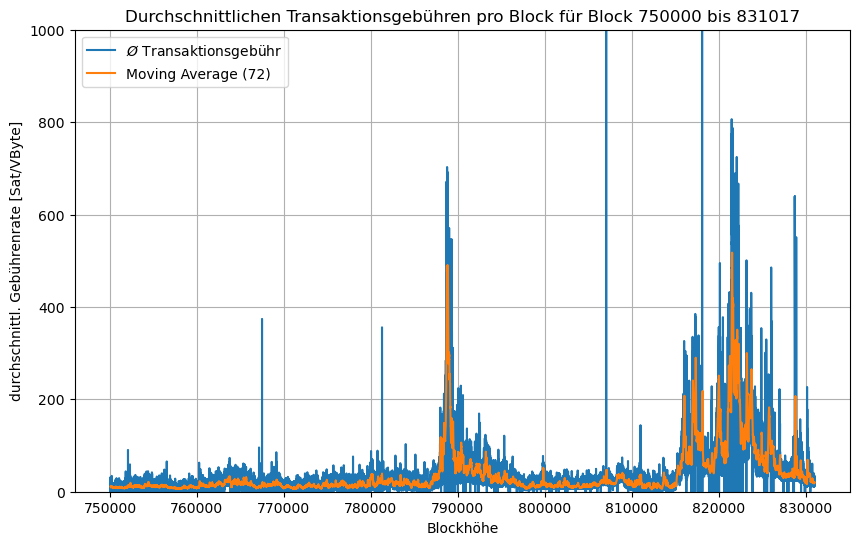

In [ ]:
moving_average = 72

plt.figure(figsize=(10,6))

plt.ylim(0,1000)

plt.title("Durchschnittlichen Transaktionsgebühren pro Block für Block {} bis {}".format(df_only_fees["blockheight"].min(), df_only_fees["blockheight"].max()))
plt.xlabel("Blockhöhe")
plt.ylabel("durchschnittl. Gebührenrate [Sat/VByte]")

plt.plot(df_only_fees["blockheight"], df_only_fees["avg_fee"], label="$\O$ Transaktionsgebühr")
plt.plot(df_only_fees["blockheight"], df_only_fees["avg_fee"].rolling(moving_average).mean(), label="Moving Average ({moving_average})".format(moving_average=moving_average))

plt.legend()
plt.grid()


Text(0, 0, 'Hallo Leonhard')

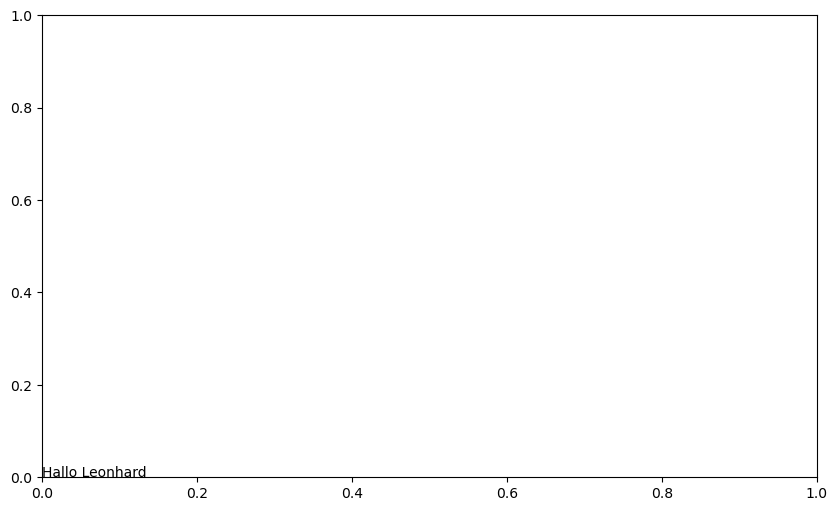

In [ ]:
plt.figure(figsize=(10,6))
plt.text(0,0,s="Hallo Leonhard")